In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import matplotlib.pylab as plt
import numpy as onp
import jax.numpy as np
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

In [31]:
from dist import GaussianMixture
mixture = GaussianMixture(np.array([-10, 10]), np.array([1, 1]))

In [32]:
key = jax.random.PRNGKey(20)
data = mixture.sample(1000, key)

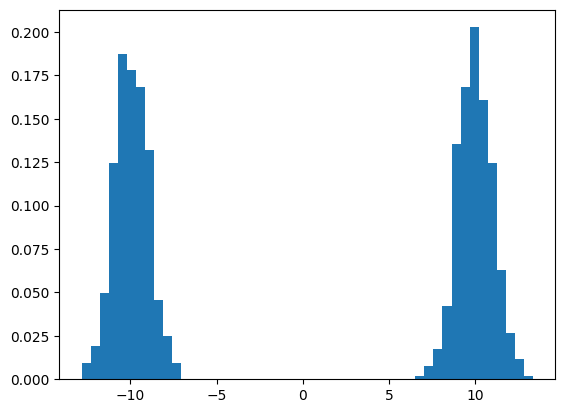

In [34]:
#plt.scatter(data[:,0], data[:,1], alpha=0.7)
plt.hist(data, bins=50, density=True)
plt.show()

In [35]:
from mcmc import LangevinDynamics

In [44]:
grad_log_p = jax.jit(jax.grad(mixture.log_p))

n_particles = 100
starter_points = jax.random.normal(key, shape=(n_particles, 1, mixture.means.shape[1])) * 5
starter_keys = jax.random.split(key, n_particles)

sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=100, gamma=5e-1, burnin_steps=0)

In [45]:
final_xs, samples = jax.vmap(sampler)(starter_points, starter_keys)

In [46]:
print(samples.shape)
samples = samples.reshape(-1, mixture.means.shape[1])

(100, 100, 1)


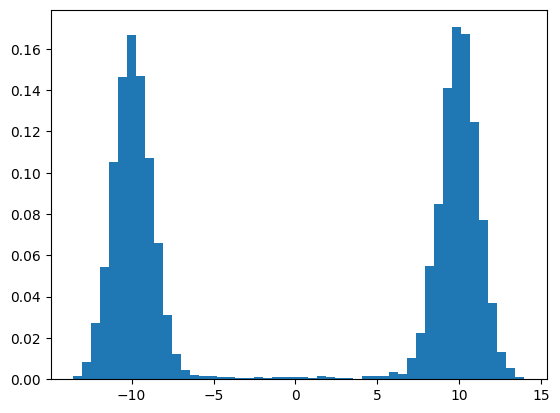

In [47]:
#plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
plt.hist(samples, bins=50, density=True)
plt.show()

In [48]:
from folx import forward_laplacian

class Generator:
    def __init__(self, grad_log_p, g):
        self.grad_log_p = grad_log_p
        self.fwd_g = forward_laplacian(g)
    
    def __call__(self, x):
        output_g = self.fwd_g(x)
        return np.dot(self.grad_log_p(x), output_g.jacobian.dense_array) + output_g.laplacian

In [49]:
import equinox as eqx
from jax import nn, random

class ControlVariateModel(eqx.Module):
    """Control Variate NN model."""

    mlp: eqx.Module

    def __init__(
        self,
        in_size=1,
        width_size=4096,
        depth=1,
        activation=nn.relu,
        key=random.PRNGKey(45),
    ):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=1,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        """
        return self.mlp(x).squeeze()

In [50]:
def cv_loss(cv_model: eqx.Module, fn: tp.Callable, data: np.ndarray) -> float:
    gx = jax.vmap(cv_model)(data)
    fx = jax.vmap(fn)(data)
    f_wave = fx - fx.mean()
    grad_g = jax.vmap(jax.grad(cv_model))(data)
    loss = -2 * gx * f_wave + (grad_g ** 2).sum(axis=1)
    return loss.mean()

In [51]:
def fit_cv(cv_model: eqx.Module, fn: tp.Callable, data: np.ndarray, optimizer: optax.GradientTransformation, loss: tp.Callable, n_steps: int = 1000):
    opt_state = optimizer.init(eqx.filter(cv_model, eqx.is_array))
    dloss = eqx.filter_jit(eqx.filter_value_and_grad(loss))
    
    @eqx.filter_jit
    def step(cv_model, data, opt_state):
        loss_score, grads = dloss(cv_model, fn, data)
        updates, opt_state = optimizer.update(grads, opt_state)
        cv_model = eqx.apply_updates(cv_model, updates)
        return cv_model, opt_state, loss_score
    
    loss_history = []
    for _ in tqdm(range(n_steps)):
        cv_model, opt_state, loss_score = step(cv_model, data, opt_state)
        loss_history.append(loss_score)
    return cv_model, loss_history

In [20]:
#generator(np.ones((2), dtype=float))
#cv_model(np.ones((2), dtype=float)).shape

In [53]:
fn = lambda x: x.sum()
cv_model = ControlVariateModel(in_size=mixture.means.shape[1], key=key)

optimizer = optax.adam(learning_rate=5e-3)

updated_model, loss_history = fit_cv(
    cv_model, 
    fn,
    samples,  
    optimizer,
    cv_loss, 
    n_steps=1_000,
)

100%|██████████| 1000/1000 [00:05<00:00, 192.20it/s]


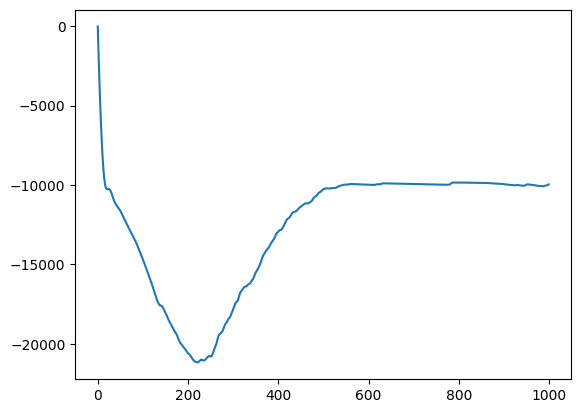

In [54]:
plt.plot(loss_history)

In [55]:
generator = Generator(grad_log_p, cv_model)

In [56]:
(jax.vmap(fn)(samples) + jax.vmap(generator)(samples)).mean()

Array(0.2105475, dtype=float32)